In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import re
import unicodedata
from string import punctuation
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, classification_report
import xgboost as xgb
from wordcloud import WordCloud

### **Change File path**

In [2]:
#raw_path = '/content/drive/MyDrive/Olist/'
olist_customer = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('olist_products_dataset.csv')
olist_sellers = pd.read_csv('olist_sellers_dataset.csv')
olist_translation= pd.read_csv('product_category_name_translation.csv')

'Observably, more higher rated scores than lower rated'

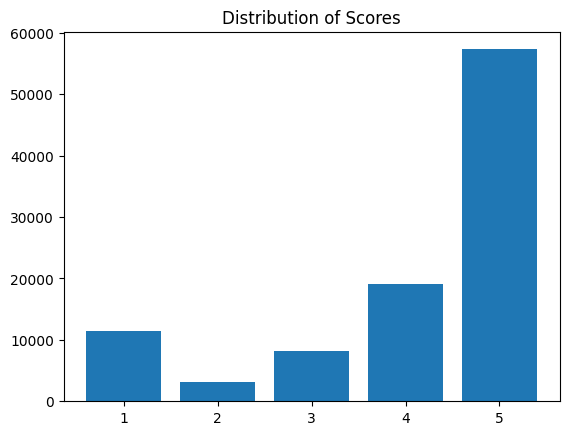

In [ ]:
df_review_orders = olist_order_reviews.merge(olist_orders, left_on='order_id', right_on='order_id', how='left')

df_histogram_review = df_review_orders.pivot_table(values=['order_id'], index=['review_score'], aggfunc='count').reset_index()

plt.bar(df_histogram_review['review_score'], df_histogram_review['order_id'])
plt.title('Distribution of Scores')

'''Observably, more higher rated scores than lower rated'''

In [ ]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


In [ ]:
olist_order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


## **Exploratory Data Analysis**

In [4]:
customer = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_item = pd.read_csv('olist_order_items_dataset.csv')
order_payment = pd.read_csv('olist_order_payments_dataset.csv')
order_review = pd.read_csv('olist_order_reviews_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')
product = pd.read_csv('olist_products_dataset.csv')
seller = pd.read_csv('olist_sellers_dataset.csv')
product_category = pd.read_csv('product_category_name_translation.csv')

df = order.merge(order_item,on='order_id').merge(order_payment,on='order_id')\
          .merge(order_review,on='order_id').merge(customer,on='customer_id')\
          .merge(product,on='product_id').merge(seller,on='seller_id')

### order payment information

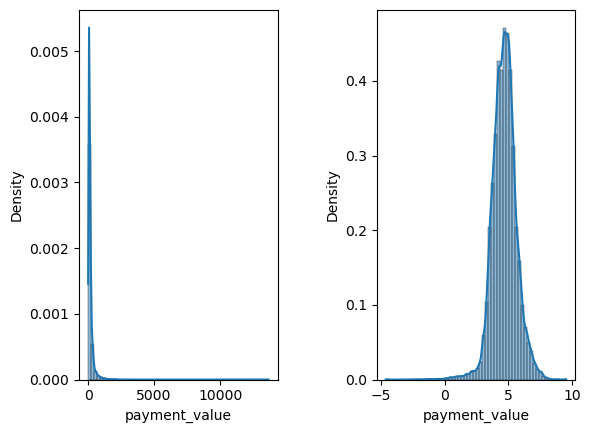

In [5]:
plt.subplot(1,2,1)
sns.histplot(x=df['payment_value'],bins=60,kde=True,stat='density')
plt.subplot(1,2,2)
sns.histplot(x=df['payment_value'].transform(np.log),bins=60,kde=True,stat='density')

plt.subplots_adjust(wspace=0.5)

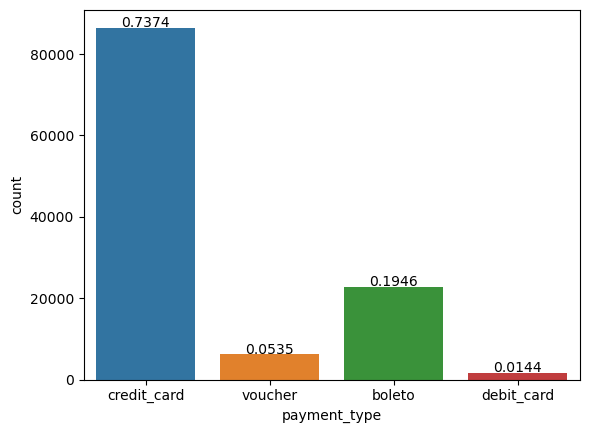

In [6]:
g = sns.countplot(x=df['payment_type'])
for p in g.patches:
# get the height of each bar
    height = p.get_height()
    g.text(x = p.get_x()+(p.get_width()/2),y = height+100,s=np.round(height/len(df),4),ha="center")

<Axes: ylabel='payment_type'>

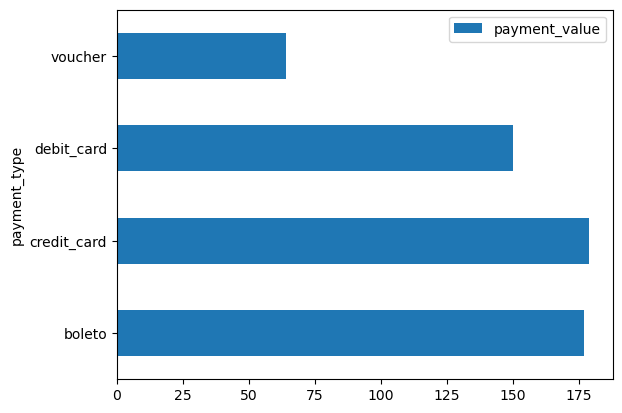

In [7]:
df[['payment_value','payment_type']].groupby('payment_type').mean().plot(kind='barh')

For large amount payment, it tends to choose credit card and boleto. And for small amount payment, people tends to use voucher.

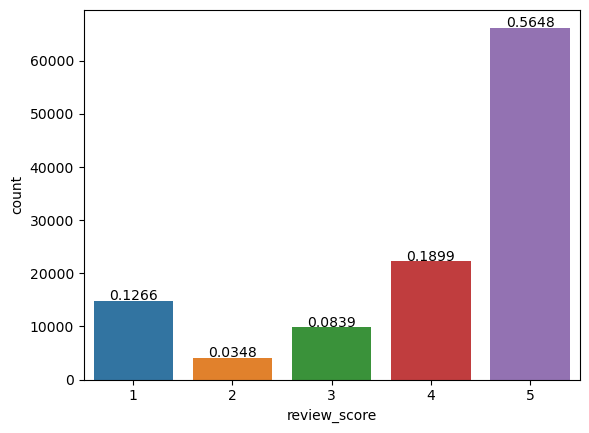

In [8]:
g = sns.countplot(x=df["review_score"])
for p in g.patches:
# get the height of each bar
    height = p.get_height()
    g.text(x = p.get_x()+(p.get_width()/2),y = height+100,s=np.round(height/len(df),4),ha="center")

More than 60% of orders obtain good scores(larger than or equal to 4).

<Axes: xlabel='seller_state'>

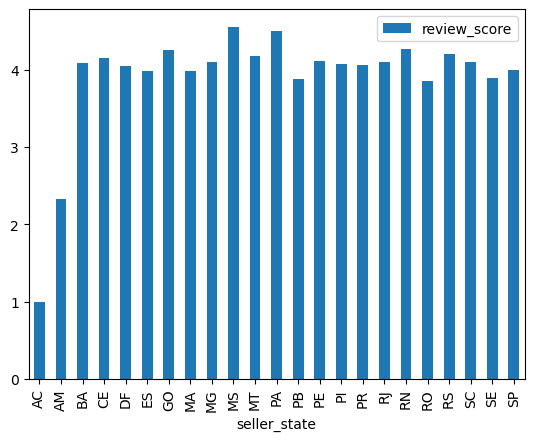

In [9]:
df[["review_score","seller_state"]].groupby("seller_state").mean().plot(kind='bar')

From the bar plot, we can see that the products form state AC and AM have lower review scores.

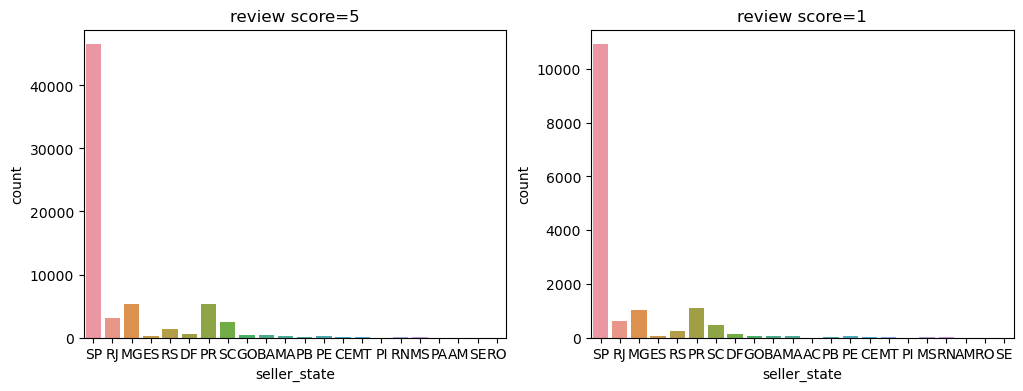

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x=df["seller_state"][df["review_score"]==5])
plt.title(f'review score=5')
plt.subplot(1,2,2)
sns.countplot(x=df["seller_state"][df["review_score"]==1])
plt.title(f'review score=1')

plt.subplots_adjust(wspace=0.2)

Best and worst review score show similar distribution in each state. 

### customer and seller information

Text(0, 0.5, 'Ratio')

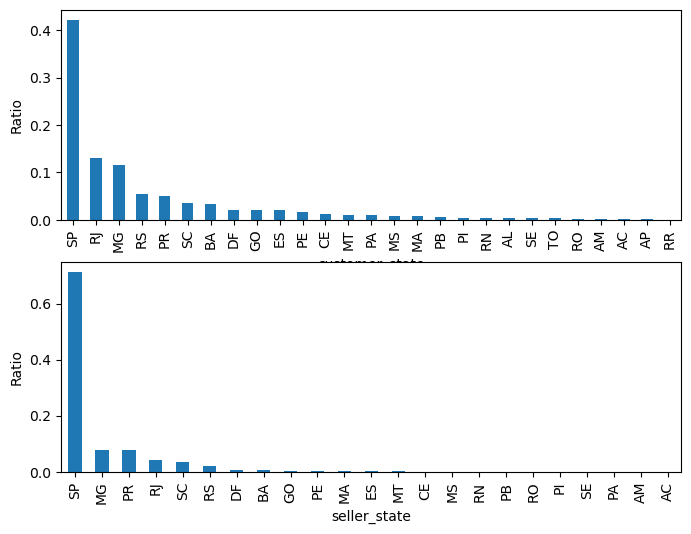

In [11]:
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
(df["customer_state"].value_counts()/len(df)).plot(kind='bar')
plt.xlabel('customer_state')
plt.ylabel('Ratio')

plt.subplot(2,1,2)
(df["seller_state"].value_counts()/len(df)).plot(kind='bar')
plt.xlabel('seller_state')
plt.ylabel('Ratio')

From these two plots, we can see that sellers and customers are mostly come from SP.It's san polo which is the largest city in Brazil.

### item information

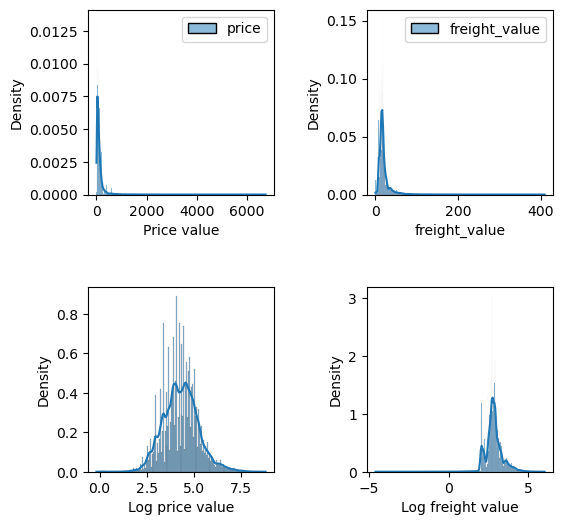

In [12]:
plt.figure(figsize=(6,6))
plt.subplot(2,2,1)
sns.histplot(df[['price']],stat='density',kde=True)
plt.xlabel('Price value')
plt.ylabel('Density')

plt.subplot(2,2,2)
sns.histplot(df[['freight_value']],stat='density',kde=True)
plt.xlabel('freight_value')
plt.ylabel('Density')


plt.subplot(2,2,3)
sns.histplot(df['price'].transform(np.log),stat='density',kde=True)
plt.xlabel('Log price value')
plt.ylabel('Density')

plt.subplot(2,2,4)
sns.histplot(df['freight_value'].transform(np.log),stat='density',kde=True)
plt.xlabel('Log freight value')
plt.ylabel('Density')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

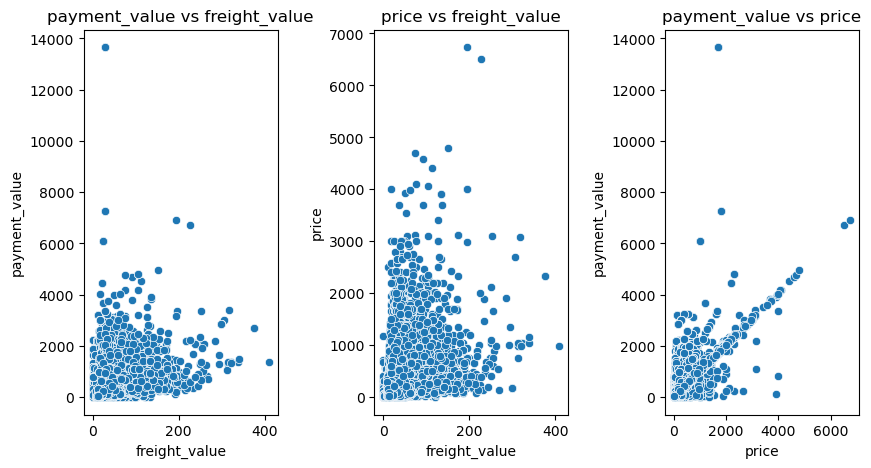

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.scatterplot(data=df,x="freight_value",y="payment_value")
plt.title(f'payment_value vs freight_value')

plt.subplot(1,3,2)
sns.scatterplot(data=df,x="freight_value",y="price")
plt.title('price vs freight_value')

plt.subplot(1,3,3)
sns.scatterplot(data=df,x="price",y="payment_value")
plt.title('payment_value vs price')

plt.subplots_adjust(wspace=0.5)

price value and payment_value show stronger linear relationship than that fo freight value and payment value.

### Correlation analysis

In [14]:
df_numerical = df.select_dtypes(include = 'number').drop(columns=['order_item_id','customer_zip_code_prefix','seller_zip_code_prefix'])
df_numerical.head()

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,29.99,8.72,1,1,18.12,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,29.99,8.72,3,1,2.00,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,29.99,8.72,2,1,18.59,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0
3,29.99,7.78,1,3,37.77,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0
4,29.99,7.78,1,1,37.77,5,40.0,268.0,4.0,500.0,19.0,8.0,13.0


<Axes: >

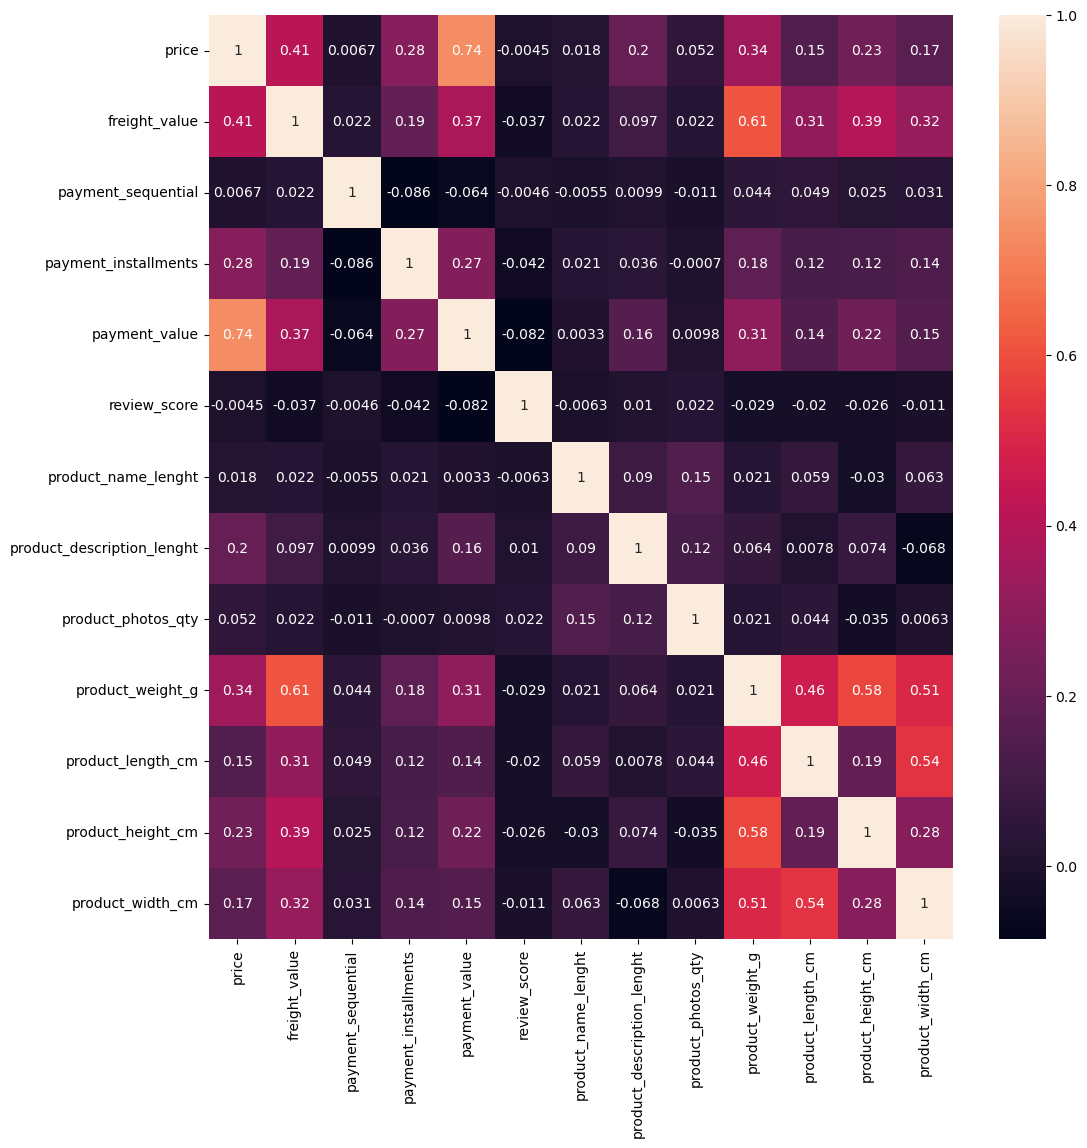

In [15]:
df_numerical_corr = df_numerical.corr()
plt.figure(figsize=(12,12))
sns.heatmap(df_numerical_corr,annot=True)

<Axes: >

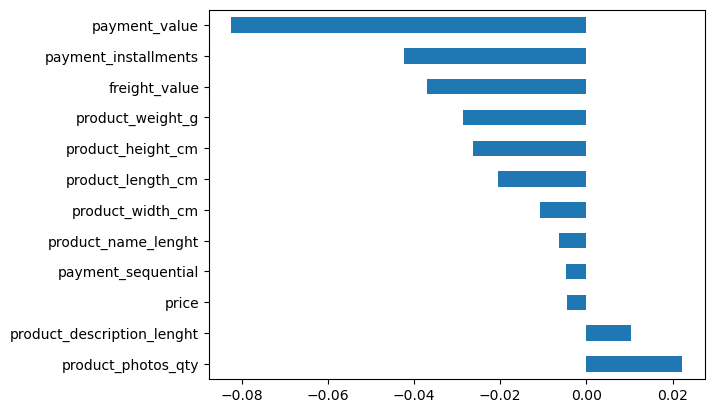

In [16]:
df_numerical_corr['review_score'].sort_values(ascending=False)[1:].plot(kind='barh')

From the correlation analysis, we can see that the positive related features are `product_desciription_length` and `product_photos_qty`.

## **Classification - Identifying top 3-5 features affecting customer reviews**

Linear Regression: https://www.kaggle.com/code/andresionek/predicting-customer-satisfaction#g.-Selecting-a-Model

In [ ]:
# Merge require tables
full_df = olist_orders.merge(olist_order_reviews, on='order_id')\
                   .merge(olist_order_payments, on='order_id')\
                   .merge(olist_customer, on='customer_id')\
                   .merge(olist_order_items, on='order_id')\
                   .merge(olist_products, on='product_id')\
                   .merge(olist_sellers, on='seller_id')

# Drop duplicates
full_df.drop_duplicates(inplace = True)

In [ ]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [ ]:
df_summary(full_df)

Dataset Shape: (117329, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
1,customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
2,order_status,object,0,7,delivered,0.19
3,order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
4,order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
5,order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
6,order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
7,order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
8,review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
9,review_score,int64,0,5,4,1.77


In [ ]:
# Conversion from string to datetime
datetime_columns = ['order_purchase_timestamp', 'order_approved_at', 
                    'order_delivered_carrier_date', 'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 'review_answer_timestamp',
                    'shipping_limit_date']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

# Change of mispelled names
full_df = full_df.rename(columns={'product_name_lenght': 'product_name_length', 'product_description_lenght': 'product_description_length'})

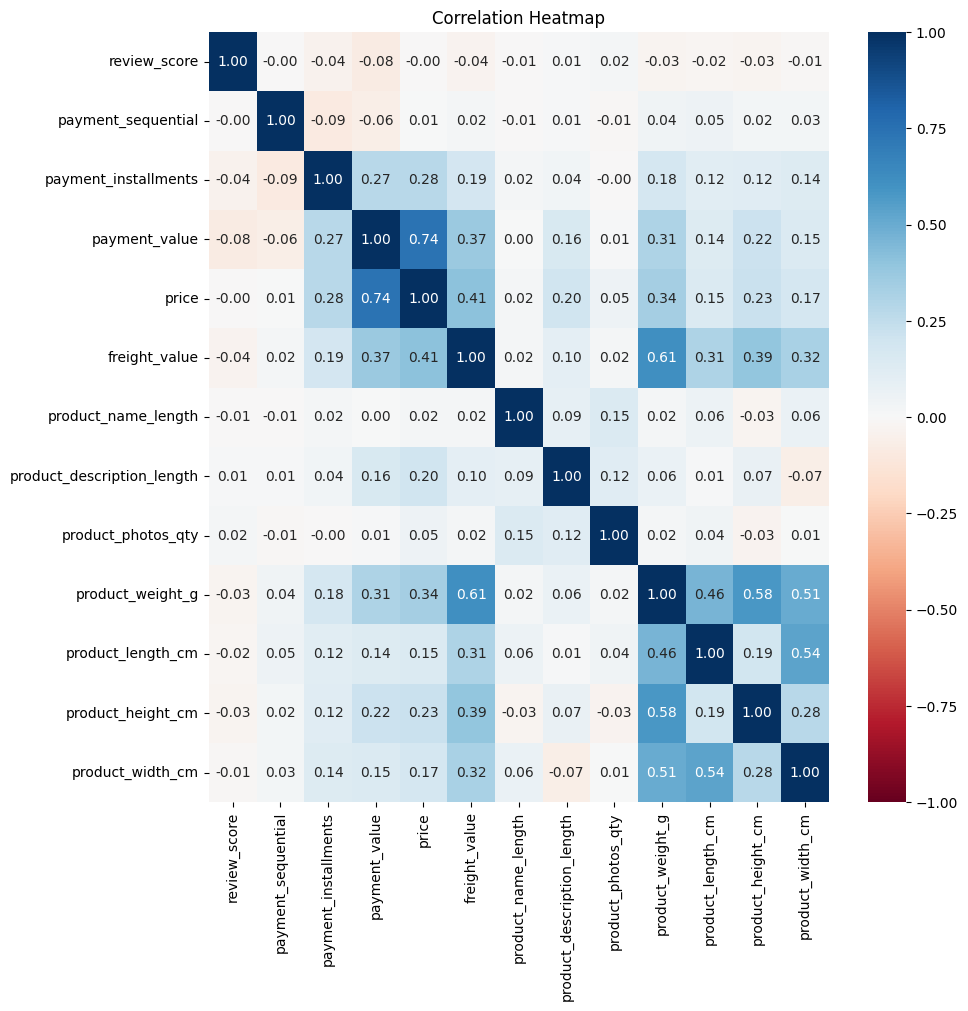

In [ ]:
# Correaltion of numeric vaLues
numeric_columns = ['review_score', 'payment_sequential', 'payment_installments',
                   'payment_value', 'price', 'freight_value', 'product_name_length',
                   'product_description_length', 'product_photos_qty', 'product_weight_g',
                   'product_length_cm', 'product_height_cm', 'product_width_cm']
numeric_df = full_df[numeric_columns]
corr = numeric_df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

# Price and payment value has high correlation > 0.7

review_score == 5: 66264
review_score == 4: 22286
review_score == 3: 9840
review_score == 2: 4085
review_score == 1: 14854


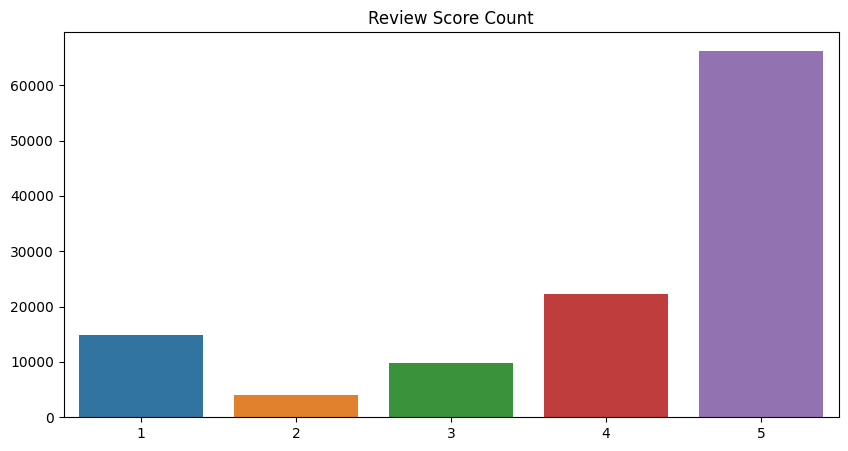

In [ ]:
print("review_score == 5: %d" % len(full_df[full_df['review_score']==5]))
print("review_score == 4: %d" % len(full_df[full_df['review_score']==4]))
print("review_score == 3: %d" % len(full_df[full_df['review_score']==3]))
print("review_score == 2: %d" % len(full_df[full_df['review_score']==2]))
print("review_score == 1: %d" % len(full_df[full_df['review_score']==1]))
score_list = [len(full_df[full_df['review_score']==1]), 
              len(full_df[full_df['review_score']==2]),
              len(full_df[full_df['review_score']==3]),
              len(full_df[full_df['review_score']==4]),
              len(full_df[full_df['review_score']==5])]

plt.figure(figsize=(10,5))
chart = sns.barplot(x=[1,2,3,4,5], y=score_list)
chart.set(title="Review Score Count")
plt.show()

### **FEATURE ENGINEERING**

review_score == 2: 66264
review_score == 1: 32126
review_score == 0: 18939


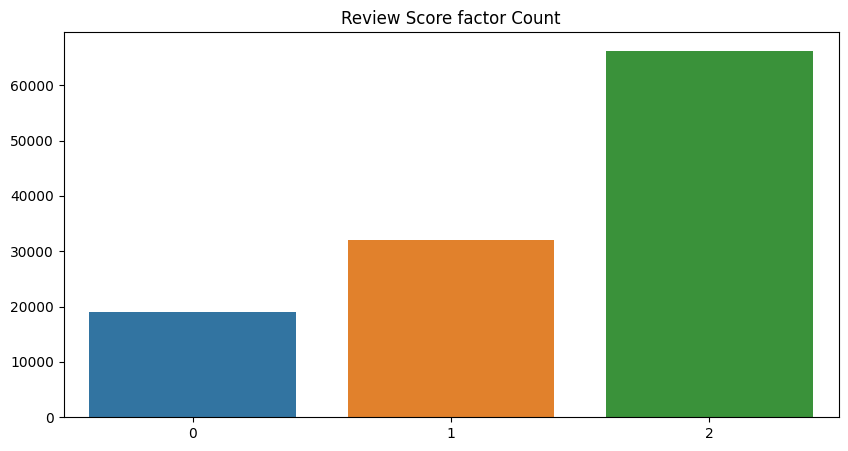

In [ ]:
# Clone `full_df` into `feature_df` which will be used for modeling later
feature_df = full_df

# Stacking `review_score`
feature_df.loc[feature_df['review_score'] == 5, "review_score_factor"] = 2
feature_df.loc[feature_df['review_score'] <= 4, "review_score_factor"] = 1
feature_df.loc[feature_df['review_score'] <= 2, "review_score_factor"] = 0


print("review_score == 2: %d" % len(full_df[full_df['review_score_factor']==2]))
print("review_score == 1: %d" % len(full_df[full_df['review_score_factor']==1]))
print("review_score == 0: %d" % len(full_df[full_df['review_score_factor']==0]))
score_list = [len(full_df[full_df['review_score_factor']==0]), 
              len(full_df[full_df['review_score_factor']==1]),
              len(full_df[full_df['review_score_factor']==2]),]

plt.figure(figsize=(10,5))
chart = sns.barplot(x=[0,1,2], y=score_list)
chart.set(title="Review Score factor Count")
plt.show()

In [ ]:
# Payment_value and price correlated > 0.7
price_median = feature_df['price'].median();
feature_df.loc[feature_df['price'] >= price_median, "price_factor"] = 1
feature_df.loc[feature_df['price'] < price_median, "price_factor"] = 0

In [ ]:
# Drop nan data or convert to 0
feature_df.loc[feature_df['product_photos_qty'].isnull(), "product_photos_qty"] = 0
feature_df.loc[feature_df['product_description_length'].isnull(), "product_description_length"] = 0
feature_df = feature_df.dropna(subset=['product_weight_g', 'product_name_length'])

In [ ]:
# Convert to order status to delivered or not delivered
feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
feature_df.loc[feature_df['order_status'] != 'delivered', "if_delivered"] = 0

# Take non-delivered cist
feature_df.loc[feature_df['order_delivered_customer_date'].isnull(), "order_delivered_customer_date"] = feature_df['order_estimated_delivery_date']

# Keep the difference in days to the column
feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days

# Number of days from order purchase date to deliver customer date
feature_df['delivery_duration'] = (feature_df['order_delivered_customer_date'] - feature_df['order_purchase_timestamp']).dt.days

# One-hot encode for customer state and seller state
d1 = pd.get_dummies(feature_df[['customer_state', 'seller_state']])
feature_df = pd.concat([feature_df, d1], axis=1)

# Join to get english category name and one hot encoding for category name
feature_df = feature_df.merge(olist_translation, on='product_category_name')
d2 = pd.get_dummies(feature_df[['product_category_name_english']])
feature_df = pd.concat([feature_df, d2], axis=1)

<ipython-input-13-58aff6798433>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df.loc[feature_df['order_status'] == 'delivered', "if_delivered"] = 1
<ipython-input-13-58aff6798433>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df['actual_est_delivery_diff'] = (feature_df['order_estimated_delivery_date'] - feature_df['order_delivered_customer_date']).dt.days
<ipython-input-13-58aff6798433>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [ ]:
df_summary(feature_df)

Dataset Shape: (115608, 166)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,96515,e481f51cbdc54678b7cc49136f2d6af7,16.41
1,customer_id,object,0,96515,9ef432eb6251297304e76186b10a928d,16.41
2,order_status,object,0,7,delivered,0.18
3,order_purchase_timestamp,datetime64[ns],0,95988,2017-10-02 10:56:33,16.40
4,order_approved_at,datetime64[ns],14,88331,2017-10-02 11:07:15,16.24
...,...,...,...,...,...,...
161,product_category_name_english_stationery,uint8,0,2,0,0.16
162,product_category_name_english_tablets_printing...,uint8,0,2,0,0.01
163,product_category_name_english_telephony,uint8,0,2,0,0.24
164,product_category_name_english_toys,uint8,0,2,0,0.23


## **Dropping of unnecessary columns, splitting to train, test data set and standardization**

In [ ]:
drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'freight_value', 'product_category_name', 'product_category_name_english', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state']




rf_feature_df = feature_df.drop(drop_columns, axis=1)

train, test = train_test_split(rf_feature_df, test_size=0.2,random_state=42)

# Split feature and label with our dataframe
Y_train = train['review_score_factor']
X_train =  train.drop('review_score_factor', axis=1)
Y_test = test['review_score_factor']
X_test =  test.drop('review_score_factor', axis=1)

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Transform the training and test data (Standardization)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = train.drop('review_score_factor', axis=1).columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = test.drop('review_score_factor', axis=1).columns)

In [ ]:
df_summary(X_train_scaled)

Dataset Shape: (92486, 131)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,payment_installments,float64,0,24,0.018511,2.48
1,payment_value,float64,0,26428,-0.475525,13.90
2,product_name_length,float64,0,66,1.018253,5.03
3,product_description_length,float64,0,2887,-0.740864,10.43
4,product_photos_qty,float64,0,19,-0.700999,2.17
...,...,...,...,...,...,...
126,product_category_name_english_stationery,float64,0,2,-0.151532,0.15
127,product_category_name_english_tablets_printing...,float64,0,2,-0.027125,0.01
128,product_category_name_english_telephony,float64,0,2,-0.207026,0.25
129,product_category_name_english_toys,float64,0,2,-0.195896,0.23


# **Regression**

In [ ]:
# Normal linear regression
from sklearn import linear_model
regr1 = linear_model.LinearRegression()
# Implement a standard regression
regr1.fit(X_train_scaled, Y_train)
sse = np.sum((regr1.predict(X_test_scaled) - Y_test) ** 2)
ssr = np.sum((regr1.predict(X_test_scaled) - np.mean(Y_test)) ** 2)
sst = np.sum((Y_test - np.mean(Y_test)) ** 2)
print('Total sum of squares:', sst)
print('Explained sum of squares:', ssr)
print('Residual sum of squares:', sse)
print('R^2 score computed from score function:', regr1.score(X_test_scaled, Y_test))
print('R^2 score computed from ssr / sst:', ssr / sst)

Total sum of squares: 13068.39114263472
Explained sum of squares: 1727.0321718633886
Residual sum of squares: 11236.525400684342
R^2 score computed from score function: 0.14017530711749537
R^2 score computed from ssr / sst: 0.1321533885092455


In [ ]:
# try Lasso, ridge and SGD, still produce low r-square
for alpha in [1, 0.1, 0.01, 0.001]:
  ridge = linear_model.Ridge(alpha = alpha)
  ridge.fit(X_train_scaled, Y_train)
  lasso = linear_model.Lasso(alpha = alpha)
  lasso.fit(X_train_scaled, Y_train)
  sgd1 = linear_model.SGDRegressor(tol = 1.0e-4, max_iter = 200, penalty = 'l1', alpha = alpha)
  sgd1.fit(X_train_scaled, Y_train)
  sgd2 = linear_model.SGDRegressor(tol = 1.0e-4, max_iter = 200, penalty = 'l2', alpha = alpha)
  sgd2.fit(X_train_scaled, Y_train)
  print('alpha = {}'.format(alpha))
  print('lasso score:', lasso.score(X_test_scaled, Y_test))
  print('sgd_l1 score:', sgd1.score(X_test_scaled, Y_test))
  #print(lasso.coef_, lasso.intercept_)
  #print(sgd1.coef_, sgd1.intercept_)
  print('ridge score:', ridge.score(X_test_scaled, Y_test))
  print('sgd_l2 score:', sgd2.score(X_test_scaled, Y_test))
  #print(ridge.coef_, ridge.intercept_)
  #print(sgd2.coef_, sgd2.intercept_)


alpha = 1
lasso score: -3.3788137125956297e-06
sgd_l1 score: -0.000429780667925872
ridge score: 0.1402301363447629
sgd_l2 score: 0.10771952450301503
alpha = 0.1
lasso score: 0.09008448879981745
sgd_l1 score: 0.09121731115393539
ridge score: 0.1402301698376307
sgd_l2 score: -1.8422552234502518e+21
alpha = 0.01
lasso score: 0.13467152023475848
sgd_l1 score: -2.2855931369446368e+21
ridge score: 0.14023017318510633
sgd_l2 score: -3.760489784497285e+21
alpha = 0.001
lasso score: 0.14024805362932702
sgd_l1 score: -2.4504000920041664e+21
ridge score: 0.1402301735198357
sgd_l2 score: -3.9547179929634325e+21


In [ ]:
# We try to create some interaction variables to see if it helps improve our regression
drop_columns = ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                'order_delivered_customer_date', 'order_estimated_delivery_date', 'review_id', 'review_comment_title', 'review_score', \
                'review_creation_date', 'review_comment_message', 'review_answer_timestamp', 'payment_sequential', 'payment_type', 'customer_unique_id', \
                'customer_zip_code_prefix', 'customer_city', 'customer_state', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', \
                'product_category_name', 'product_category_name_english', 'product_length_cm', 'product_height_cm', 'product_width_cm', \
                'seller_zip_code_prefix', 'seller_city', 'seller_state']
rf_feature_df = feature_df.drop(drop_columns, axis=1)

rf_feature_df['new_value'] = rf_feature_df['payment_value'] * rf_feature_df['freight_value'] 

rf_feature_df['new_value_two'] = rf_feature_df['product_photos_qty'] * rf_feature_df['product_description_length'] 

train, test = train_test_split(rf_feature_df, test_size=0.2,random_state=42)

# Split feature and label with our dataframe
Y_train = train['review_score_factor']
X_train =  train.drop('review_score_factor', axis=1)
Y_test = test['review_score_factor']
X_test =  test.drop('review_score_factor', axis=1)

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler to the training data
scaler.fit(X_train)

# Transform the training and test data (Standardization)
X_train_scaled = scaler.transform(X_train)
#X_train_scaled = X_train
X_test_scaled = scaler.transform(X_test)
#X_test_scaled = X_test
X_train_scaled = pd.DataFrame(X_train_scaled, columns = train.drop('review_score_factor', axis=1).columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = test.drop('review_score_factor', axis=1).columns)



In [ ]:
# Adding interaction variables do not yield much better results. R square improves about 0.02
regr2 = linear_model.LinearRegression()
regr2.fit(X_train_scaled, Y_train)
sse = np.sum((regr2.predict(X_test_scaled) - Y_test) ** 2)
ssr = np.sum((regr2.predict(X_test_scaled) - np.mean(Y_test)) ** 2)
sst = np.sum((Y_test - np.mean(Y_test)) ** 2)
print('Total sum of squares:', sst)
print('Explained sum of squares:', ssr)
print('Residual sum of squares:', sse)
print('R^2 score computed from score function:', regr2.score(X_test_scaled, Y_test))
print('R^2 score computed from ssr / sst:', ssr / sst)

Total sum of squares: 13068.39114263472
Explained sum of squares: 1738.1556292585306
Residual sum of squares: 11223.346079069936
R^2 score computed from score function: 0.14118379557415095
R^2 score computed from ssr / sst: 0.13300456118029083


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'customer_state_SP'),
  Text(1, 0, 'customer_state_RJ'),
  Text(2, 0, 'customer_state_MG'),
  Text(3, 0, 'product_category_name_english_bed_bath_table'),
  Text(4, 0, 'product_category_name_english_health_beauty'),
  Text(5, 0, 'product_category_name_english_sports_leisure'),
  Text(6, 0, 'product_category_name_english_furniture_decor'),
  Text(7, 0, 'product_category_name_english_computers_accessories'),
  Text(8, 0, 'product_category_name_english_housewares'),
  Text(9, 0, 'customer_state_RS'),
  Text(10, 0, 'customer_state_PR'),
  Text(11, 0, 'product_category_name_english_watches_gifts'),
  Text(12, 0, 'seller_state_SP'),
  Text(13, 0, 'product_category_name_english_telephony'),
  Text(14, 0, 'customer_state_SC'),
  Text(15, 0, 'product_category_name_english_garden_tools'),
  Text(16, 0, 'customer_state_BA'),
  Text(17, 0, 'product_category_name_english_auto'),
  Text(18, 0, 'product_category_name

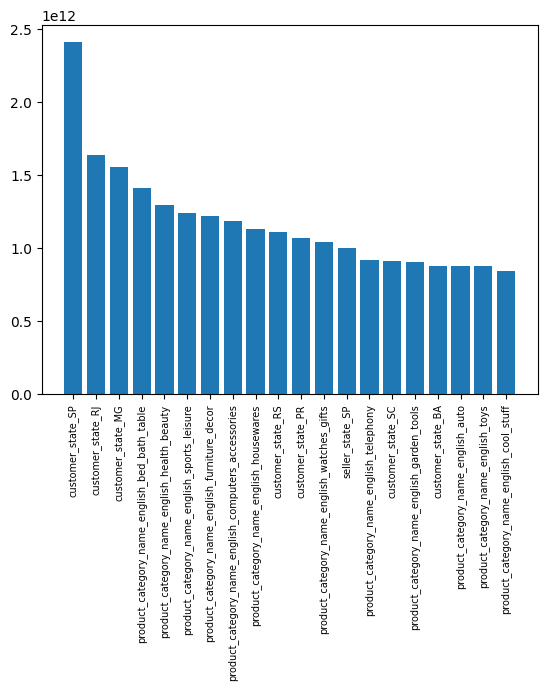

In [ ]:
# Regression for feature importance
import  matplotlib.pyplot as plt
importance = regr2.coef_
df_sort_feature = pd.DataFrame({'feature': X_train_scaled.columns, 'importance': importance})
df_sort_feature['importance'] = df_sort_feature['importance'].astype(float)
df_sort_feature = df_sort_feature.sort_values(by='importance', ascending=False)
df_sort_feature.reset_index()
#print(feat_importances)
#feat_importances  = feat_importances.sort_values['0']

#for i,v in enumerate(importance):
  #print('Feature: %0d, Score: %.5f' % (i,v), X_train_scaled.columns[i])
# plot feature importance
df_sort_feature = df_sort_feature.iloc[0:20]
plt.bar(df_sort_feature['feature'], df_sort_feature['importance'])
plt.xticks(rotation=90,size=7)
#plt.show()

## **Building of model of logistic regression**


In [ ]:
# Create an logistic regression
sm_estimator = LogisticRegression(
    solver = 'lbfgs',
    multi_class = 'multinomial',
    max_iter = 1000,
    random_state=42)

# Train model on the training data
sm_estimator.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions_te = sm_estimator.predict(X_test_scaled)
predictions_tr = sm_estimator.predict(X_train_scaled)

# Probability 
Y_scores = sm_estimator.predict_proba(X_test_scaled)[:, 1]
y_true = np.array(Y_test)

# Calulate accuracy
accuracy_tr = sum(Y_train == predictions_tr)/len(predictions_tr)
accuracy_te = sum(Y_test == predictions_te)/len(predictions_te)

print("Train accuracy: {}".format(accuracy_tr))
print("Test accuracy: {}".format(accuracy_te))

Train accuracy: 0.6026425621175097
Test accuracy: 0.605008217282242


In [ ]:
labels = ['Class 0','Class 1', 'Class 2']

def class_report(y_test, y_pred, title="", labels=labels):
    if(title != ''):
        print(title,"\n")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Class 0 pred','Class 1 pred', 'Class 2 pred'], index = ['Class 0 actual','Class 1 actual', 'Class 2 actual']), '\n')
    print(classification_report(y_test, y_pred, target_names=labels))
    print('Model Accuracy:', accuracy_score(y_test, y_pred))

class_report(Y_test, predictions_te, "Logistic Regression")

Logistic Regression 

                Class 0 pred  Class 1 pred  Class 2 pred
Class 0 actual          1144           122          2485
Class 1 actual           288           123          5873
Class 2 actual           228           137         12722 

              precision    recall  f1-score   support

     Class 0       0.69      0.30      0.42      3751
     Class 1       0.32      0.02      0.04      6284
     Class 2       0.60      0.97      0.74     13087

    accuracy                           0.61     23122
   macro avg       0.54      0.43      0.40     23122
weighted avg       0.54      0.61      0.50     23122

Model Accuracy: 0.605008217282242


In [ ]:
len(sm_estimator.coef_[0])

131

In [ ]:
X_train_scaled.columns

Index(['payment_installments', 'payment_value', 'product_name_length',
       'product_description_length', 'product_photos_qty', 'product_weight_g',
       'price_factor', 'if_delivered', 'actual_est_delivery_diff',
       'delivery_duration',
       ...
       'product_category_name_english_security_and_services',
       'product_category_name_english_signaling_and_security',
       'product_category_name_english_small_appliances',
       'product_category_name_english_small_appliances_home_oven_and_coffee',
       'product_category_name_english_sports_leisure',
       'product_category_name_english_stationery',
       'product_category_name_english_tablets_printing_image',
       'product_category_name_english_telephony',
       'product_category_name_english_toys',
       'product_category_name_english_watches_gifts'],
      dtype='object', length=131)

<Axes: title={'center': 'Feature importance (weight)'}>

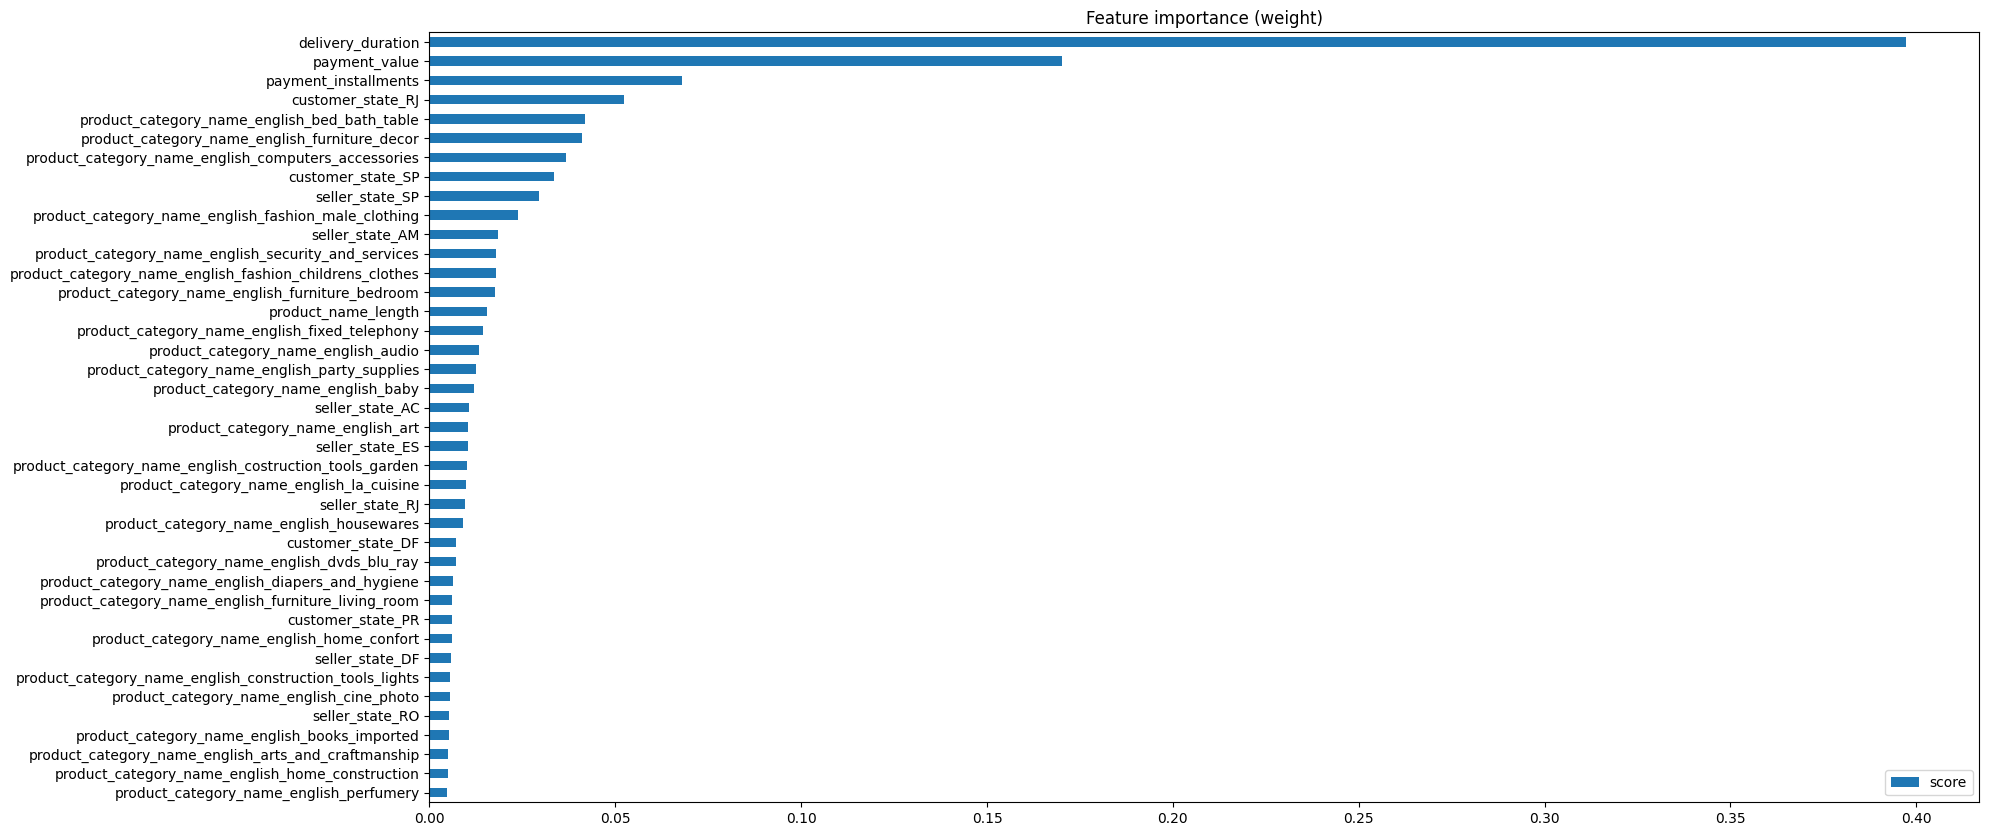

In [ ]:
keys = list(X_train_scaled.columns)
values = list(sm_estimator.coef_[0])

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(title = 'Feature importance (weight)', kind='barh', figsize = (20,10)) ## plot top 40 features

## **Building of model of XGboost**

In [ ]:
# Create an XGBoost classifier
model = xgb.XGBClassifier( n_estimators=100, random_state=42) # , objective = 'multi:softmax', num_class=3, max_depth=8,

# Train the model on the training data
model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions_te = model.predict(X_test_scaled)
predictions_tr = model.predict(X_train_scaled)

# Probability 
Y_scores = model.predict_proba(X_test_scaled)[:, 1]
y_true = np.array(Y_test)

# Calulate accuracy
accuracy_tr = sum(Y_train == predictions_tr)/len(predictions_tr)
accuracy_te = sum(Y_test == predictions_te)/len(predictions_te)

print("Train accuracy: {}".format(accuracy_tr))
print("Test accuracy: {}".format(accuracy_te))

Train accuracy: 0.6567480483532643
Test accuracy: 0.6321252486809099


In [ ]:
#a = pd.DataFrame(pd.concat(Y_test, predictions_te))
a = pd.DataFrame(Y_test).reset_index(drop=True)
b = pd.DataFrame(predictions_te, columns = ['Pred'])
c = pd.concat([a,b], axis = 1)
c[(c['review_score_factor'] == 1) & (c['Pred'] == 2)]

,review_score_factor,Pred
1,1.0,2
5,1.0,2
6,1.0,2
7,1.0,2
10,1.0,2
...,...,...
23103,1.0,2
23104,1.0,2
23110,1.0,2
23111,1.0,2


In [ ]:
labels = ['Class 0','Class 1', 'Class 2']

def class_report(y_test, y_pred, title="", labels=labels):
    if(title != ''):
        print(title,"\n")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Class 0 pred','Class 1 pred', 'Class 2 pred'], index = ['Class 0 actual','Class 1 actual', 'Class 2 actual']), '\n')
    print(classification_report(y_test, y_pred, target_names=labels))
    print('Model Accuracy:', accuracy_score(y_test, y_pred))

class_report(Y_test, predictions_te, "XGboost")


XGboost 

                Class 0 pred  Class 1 pred  Class 2 pred
Class 0 actual          1538           151          2062
Class 1 actual           286           500          5498
Class 2 actual           194           315         12578 

              precision    recall  f1-score   support

     Class 0       0.76      0.41      0.53      3751
     Class 1       0.52      0.08      0.14      6284
     Class 2       0.62      0.96      0.76     13087

    accuracy                           0.63     23122
   macro avg       0.63      0.48      0.48     23122
weighted avg       0.62      0.63      0.55     23122

Model Accuracy: 0.6321252486809099


<Axes: title={'center': 'Feature importance (weight)'}>

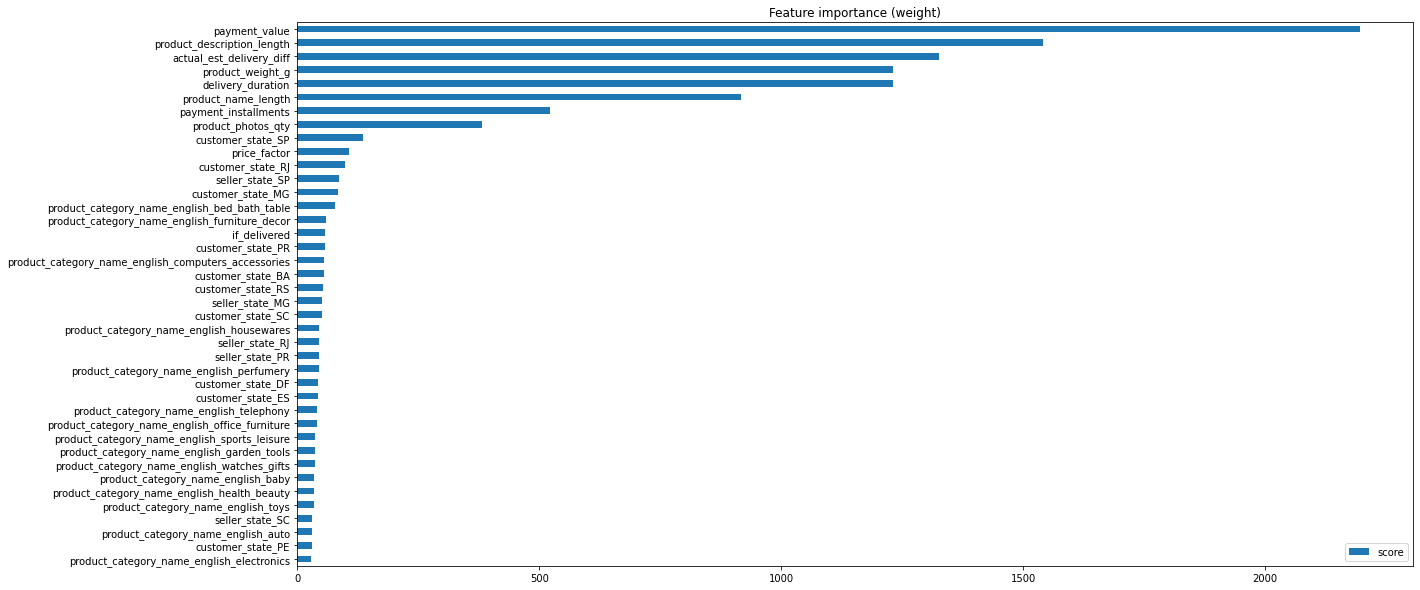

In [ ]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(title = 'Feature importance (weight)', kind='barh', figsize = (20,10)) ## plot top 40 features

<Axes: title={'center': 'Feature importance (gain)'}>

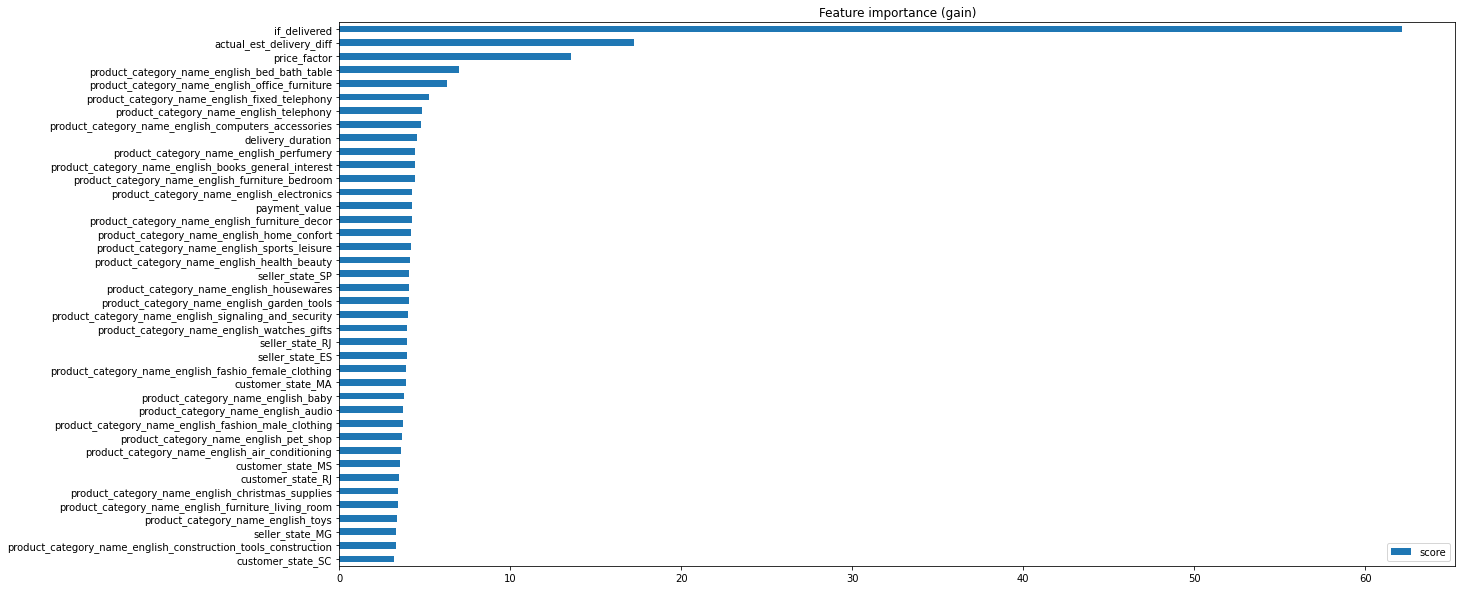

In [ ]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(title = 'Feature importance (gain)', kind='barh', figsize = (20,10)) ## plot top 40 features

## **Building of model of Random Forest**

---



---



In [ ]:
# Create an random forest classifier
model = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on the training data
model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions_te = model.predict(X_test_scaled)
predictions_tr = model.predict(X_train_scaled)

accuracy_tr = sum(Y_train == predictions_tr)/len(predictions_tr)
accuracy_te = sum(Y_test == predictions_te)/len(predictions_te)

print("Train accuracy: {}".format(accuracy_tr))
print("Test accuracy: {}".format(accuracy_te))

Train accuracy: 0.9972212010466449
Test accuracy: 0.6867918000172996


In [ ]:
labels = ['Class 0','Class 1', 'Class 2']

def class_report(y_test, y_pred, title="", labels=labels):
    if(title != ''):
        print(title,"\n")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Class 0 pred','Class 1 pred', 'Class 2 pred'], index = ['Class 0 actual','Class 1 actual', 'Class 2 actual']), '\n')
    print(classification_report(y_test, y_pred, target_names=labels))
    print('Model Accuracy:', accuracy_score(y_test, y_pred))

class_report(Y_test, predictions_te, "Random forest")

Random forest 

                Class 0 pred  Class 1 pred  Class 2 pred
Class 0 actual          2196           226          1329
Class 1 actual           286          1715          4283
Class 2 actual           228           890         11969 

              precision    recall  f1-score   support

     Class 0       0.81      0.59      0.68      3751
     Class 1       0.61      0.27      0.38      6284
     Class 2       0.68      0.91      0.78     13087

    accuracy                           0.69     23122
   macro avg       0.70      0.59      0.61     23122
weighted avg       0.68      0.69      0.65     23122

Model Accuracy: 0.6867918000172996


<Axes: title={'center': 'Feature importance'}>

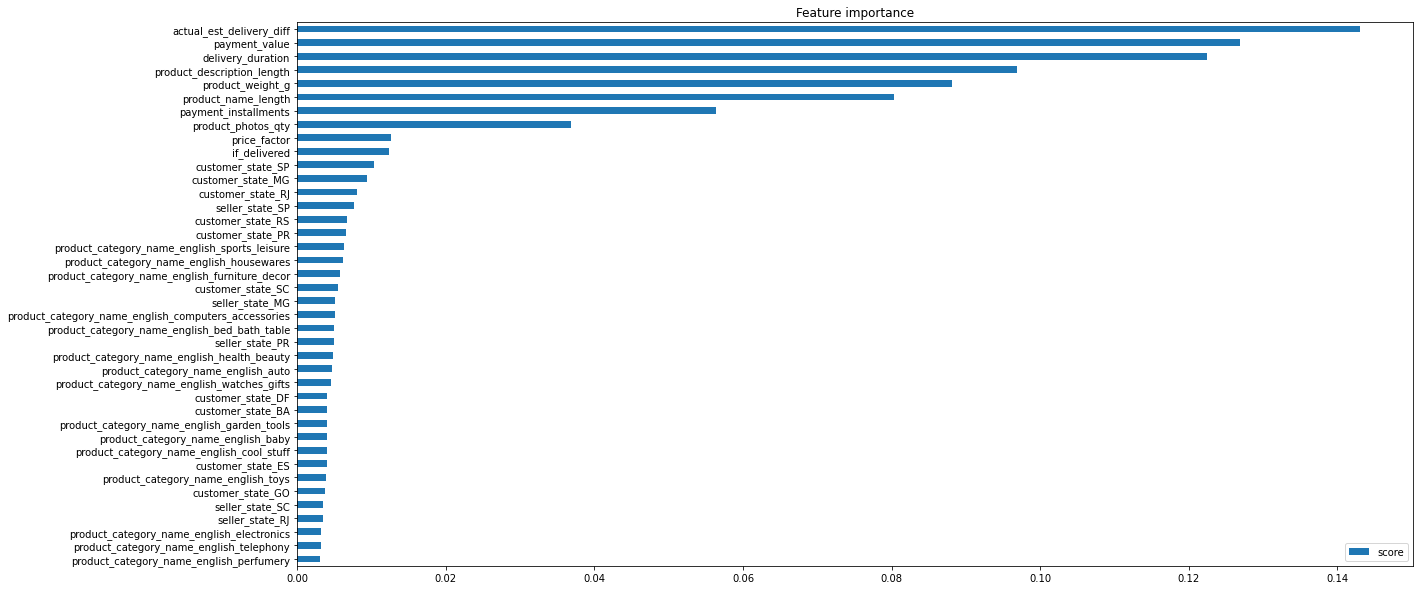

In [ ]:
# Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
keys = list(X_train_scaled.columns)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(title = 'Feature importance', kind='barh', figsize = (20,10)) ## plot top 40 features

## **Tuning of parameters for model of Random Forest (DONT RUN TAKES VERY LONG)**

In [ ]:
# DONT RUN THIS TAKES VERY LONG BEST results for this is 0.6701555013867203, {'n_estimators': 400, 'min_samples_split': 1, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}

from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [1, 2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800, 1000]}

rf_cl = RandomForestClassifier()

rf_random = RandomizedSearchCV(rf_cl, random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')

_ = rf_random.fit(X_train_scaled, Y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)

'\n# Try tuning\nfrom sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    "max_depth": [3, 5, 6, 8],\n    "learning_rate": [0.1, 0.01, 0.05],\n    "gamma": [0, 0.25, 1],\n    "reg_lambda": [0, 1, 10],\n    "scale_pos_weight": [1, 3, 5],\n    "subsample": [0.8],\n    "colsample_bytree": [0.5],\n    "n_estimators" : [100],\n}\n\n# Init classifier\nxgb_cl = xgb.XGBClassifier()\n\n# Init Grid Search\ngrid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="accuracy")\n\n# Fit\n_ = grid_cv.fit(X_train_scaled, Y_train)\n\ngrid_cv.best_score_\ngrid_cv.best_params_\n'

In [ ]:
# DONT RUN THIS TAKES VERY LONG BEST results for this is 0.6704366216259102 {'bootstrap': True, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 300}
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50, 60, None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [1, 2, 5, 7],
    'n_estimators': [100, 200, 300, 400]
}

# Init classifier
rf_cl = RandomForestClassifier()

# Init Grid Search
grid_cv_2 = GridSearchCV(rf_cl, param_grid, n_jobs=-1, cv=3, verbose = 2, scoring="accuracy")

# Fit
_ = grid_cv_2.fit(X_train_scaled, Y_train)


print(grid_cv_2.best_score_)
print(grid_cv_2.best_params_)

## **Building of model of Random Forest (TUNED)**

In [ ]:
# Create an random forest classifier
model = RandomForestClassifier(n_estimators = 300, min_samples_leaf = 1, max_features= 'sqrt', max_depth = 40, bootstrap = True, random_state = 42)

# Train the model on the training data
model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
predictions_te = model.predict(X_test_scaled)
predictions_tr = model.predict(X_train_scaled)

accuracy_tr = sum(Y_train == predictions_tr)/len(predictions_tr)
accuracy_te = sum(Y_test == predictions_te)/len(predictions_te)

print("Train accuracy: {}".format(accuracy_tr))
print("Test accuracy: {}".format(accuracy_te))

Train accuracy: 0.9732824427480916
Test accuracy: 0.6917221693625119


In [ ]:
labels = ['Class 0','Class 1', 'Class 2']

def class_report(y_test, y_pred, title="", labels=labels):
    if(title != ''):
        print(title,"\n")
    print(pd.DataFrame(confusion_matrix(y_test, y_pred), columns = ['Class 0 pred','Class 1 pred', 'Class 2 pred'], index = ['Class 0 actual','Class 1 actual', 'Class 2 actual']), '\n')
    print(classification_report(y_test, y_pred, target_names=labels))
    print('Model Accuracy:', accuracy_score(y_test, y_pred))

class_report(Y_test, predictions_te, "Random forest")

Random forest 

                Class 0 pred  Class 1 pred  Class 2 pred
Class 0 actual          2131           159          1461
Class 1 actual           244          1452          4588
Class 2 actual           176           500         12411 

              precision    recall  f1-score   support

     Class 0       0.84      0.57      0.68      3751
     Class 1       0.69      0.23      0.35      6284
     Class 2       0.67      0.95      0.79     13087

    accuracy                           0.69     23122
   macro avg       0.73      0.58      0.60     23122
weighted avg       0.70      0.69      0.65     23122

Model Accuracy: 0.6917221693625119


<Axes: title={'center': 'Feature importance'}>

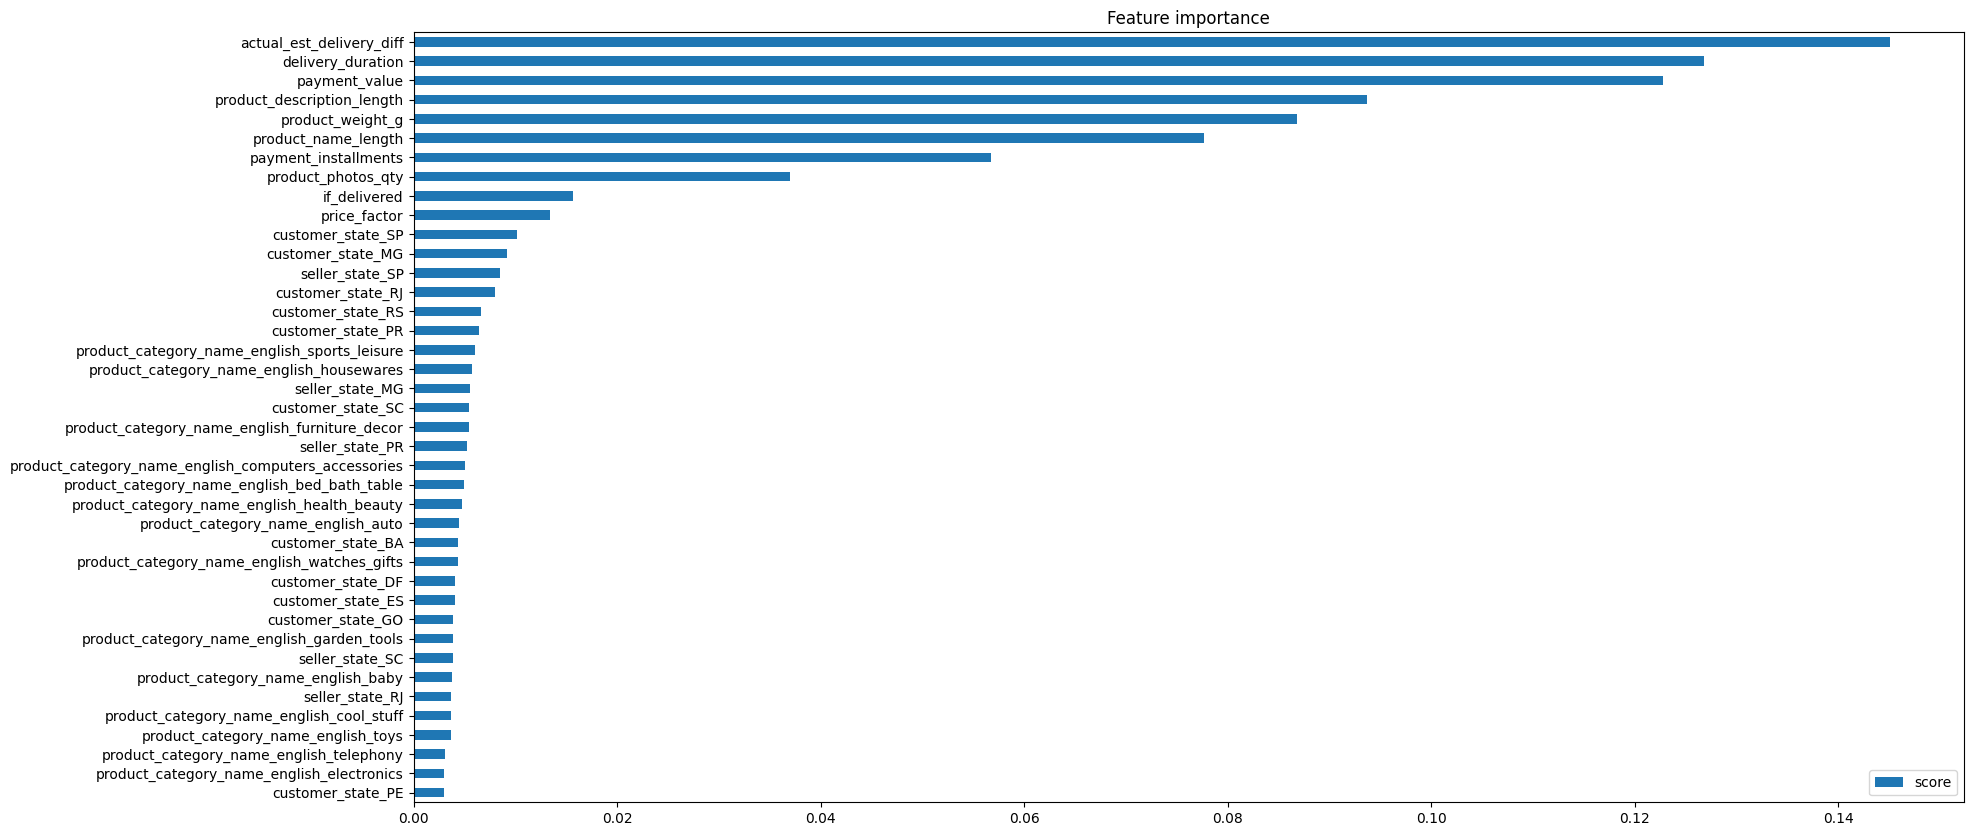

In [ ]:
# Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
keys = list(X_train_scaled.columns)
values = list(model.feature_importances_)

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)

data.nlargest(40, columns="score").sort_values(by = "score", ascending=True).plot(title = 'Feature importance', kind='barh', figsize = (20,10)) ## plot top 40 features

# **Natural Language Processing**

In [ ]:
df_test = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_test['review_score'].value_counts()

5    57328
4    19142
1    11424
3     8179
2     3151
Name: review_score, dtype: int64

In [ ]:
df_comments = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
df_comments.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


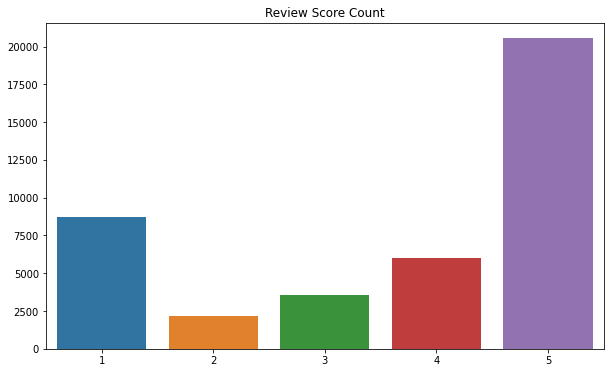

In [ ]:
score_list = [len(df_comments[df_comments['review_score']==1]), 
              len(df_comments[df_comments['review_score']==2]),
              len(df_comments[df_comments['review_score']==3]),
              len(df_comments[df_comments['review_score']==4]),
              len(df_comments[df_comments['review_score']==5])]

plt.figure(figsize=(10,6))
chart = sns.barplot(x=[1,2,3,4,5], y=score_list)
chart.set(title="Review Score Count")
plt.show()

Positive reviews: Scored 4 or 5

Negative reviews: Scored 3 and below

In [ ]:
df_comments.loc[df_comments['review_score'] >= 4, "sentiment"] = 1 #Positive
df_comments.loc[df_comments['review_score'] <= 3, "sentiment"] = 0 #Negative

In [ ]:
df_comments

,review_score,review_comment_message,sentiment
0,5,Recebi bem antes do prazo estipulado.,1.0
1,5,Parabéns lojas lannister adorei comprar pela I...,1.0
2,4,aparelho eficiente. no site a marca do aparelh...,1.0
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1.0
4,5,"Vendedor confiável, produto ok e entrega antes...",1.0
...,...,...,...
40972,4,para este produto recebi de acordo com a compr...,1.0
40973,5,Entregou dentro do prazo. O produto chegou em ...,1.0
40974,3,"O produto não foi enviado com NF, não existe v...",0.0
40975,5,"Excelente mochila, entrega super rápida. Super...",1.0


Attempt to identify which variables to use to determine review score

### **Steps to conduct Sentiment Analysis**

1. Encode to ascii ignoring errors (removes accents), reencoding again to utf8
2. Removal of stop words (Portuguese and Spanish)
3. Convert text to lowercase 
4. Tokenization to break review sentences into words
5. Removal of non-alpha strings (special characters and numbers)
6. N-grams creation (group lemmas next to each other, by comment)
7. Feature Extraction using TF-IDF and CountVectorizer
8. Use classification models to predict review scores based on review content


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Identify Portugese and Spanish Stopwords
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

stopwords_pt = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
stopwords_sp = set(remove_accents(w) for w in nltk.corpus.stopwords.words('spanish'))

stopwords = stopwords_pt.union(stopwords_sp)
stopwords.remove("nao") #'No' is an important word to determine sentiment
stopwords = list(stopwords)
len(stopwords)

473

In [ ]:
def tokenise(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = list(t for t in tokens if t not in stopwords and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))
    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    plt.gcf().set_size_inches(12, 5)
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)

In [ ]:
df_comments['review_comment_words'] = df_comments['review_comment_message'].apply(tokenise)

reviews_5s = df_comments[df_comments['review_score'] == 5]
reviews_1s = df_comments[df_comments['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

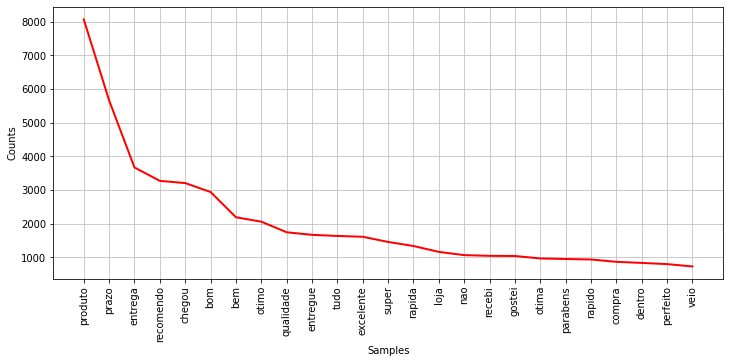

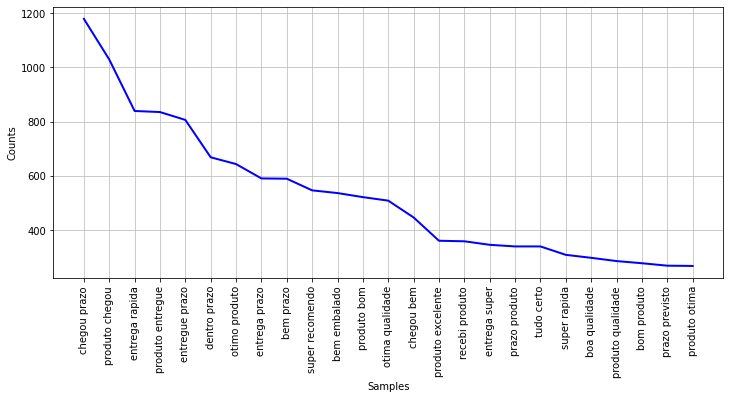

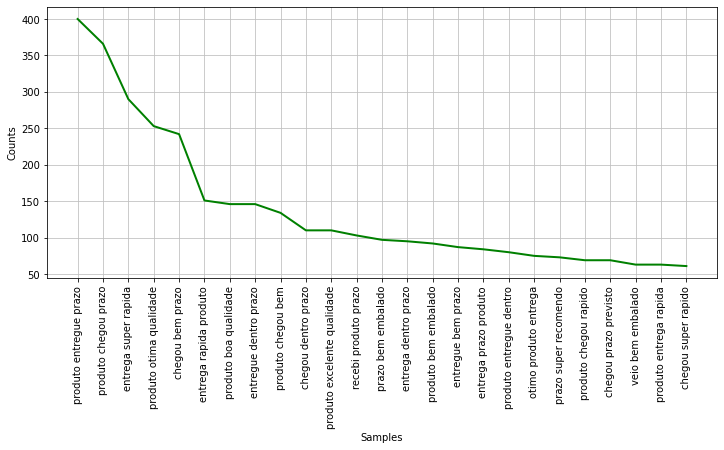

In [ ]:
# Frequency of 5 star reviews
plot_freq(unigrams_5s, 'red')
plot_freq(bigrams_5s, 'blue')
plot_freq(trigrams_5s, 'green')

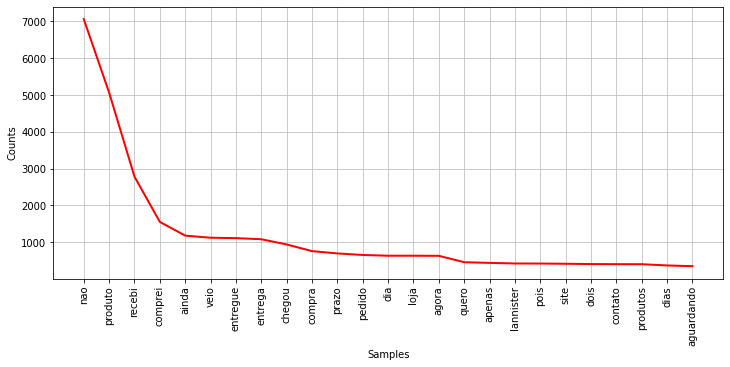

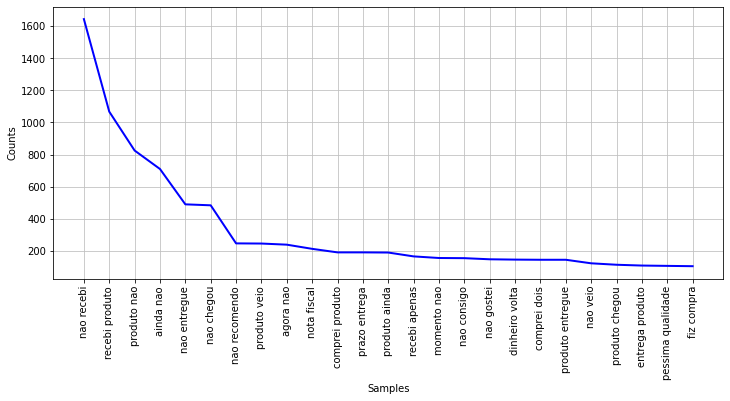

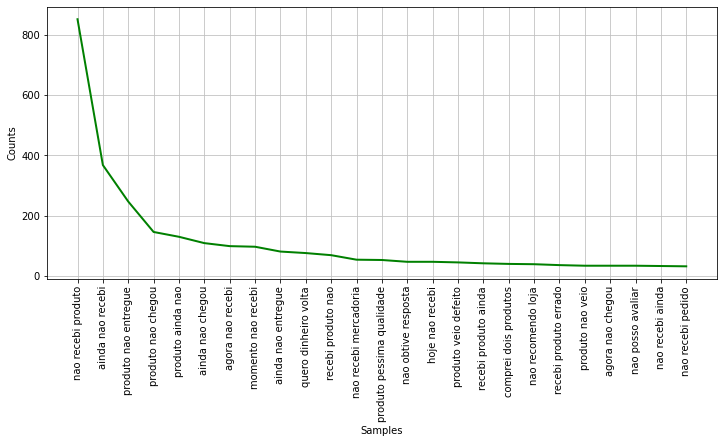

In [ ]:
#Frequency of 1 star reviews
plot_freq(unigrams_1s, 'red')
plot_freq(bigrams_1s, 'blue')
plot_freq(trigrams_1s, 'green')

In [ ]:
# function to take words as input and return dictionary with words frequency in desc order
def sort_by_frequency(words_list):
    word_counts = Counter(words_list)
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    return dict(sorted_counts)

In [ ]:
# function that translates portuguese to english and returns top 25 most frequent words 
def translate(original_words,translated_words):
    sorted_list = sort_by_frequency(original_words)
    new_dict = {}
    new_key = ""
    for i, (key, value) in enumerate(sorted_list.items()):
        if i >= 25:
            break
        new_key = translated_words[i]
        new_dict[new_key] = value
    return new_dict

In [ ]:
# This is the translation of unigram, bigram and trigrams in Portuguese. The translation is done on google translate manually
# as google translate api is not free.
#list(sort_by_frequency(unigrams_1s).keys())[:25]
unigrams_1s_translate = ['no','product','I received','I bought','yet','he came','delivered','delivery','it arrived','purchase',\
                         'term','order','day','store','now','anything','I want','just','lannister','then','site','two',\
                         'contact','products','days']
#list(sort_by_frequency(bigrams_1s).keys())[:25]
bigrams_1s_translate = ['not received','I received product','not product','not yet','not delivered','did not arrive',\
                       'I do not recommend','product came','not now','invoice','I bought product','delivery time','product yet',\
                        'I just received','I am unable','no moment','did not like','cash back','I bought two',\
                        'product delivered','did not come','product arrived','product delivery','poor quality','I made a purchase']
#list(sort_by_frequency(trigrams_1s).keys())[:25]
trigrams_1s_translate = ['I did not recieve the product',"I still haven't received",'product not delivered','product has not arrived',\
                       'product not yet','it did not arrive yet',"Now I didn't receive",'moment not received','not yet delivered',\
                         'I want money back','I received no product','I did not receive goods','poor quality product','I got no answer',\
                        "I didn't receive it today",'product came defective','I have received the product yet','I bought two products',\
                         'I do not recommend the store','I received the wrong product',"I didn't receive anything",'product did not come',\
                        "now it hasn't arrived","I can't evaluate","I didn't receive the request"]
#list(sort_by_frequency(unigrams_5s).keys())[:25]
unigrams_5s_translate = ['product','term','before','delivery','I recommend','it arrived','good','good','excellent','quality',\
                        'delivered','all','great','super','quick','store','no','I received','I liked','excellent','congratulations',\
                         'fast','purchase','inside','perfect']
#list(sort_by_frequency(bigrams_5s).keys())[:25]
bigrams_5s_translate = ['before deadline','arrived before','product arrived','fast delivery','product delivered','well before',\
                'within time','great product','delivered before','highly recommend','well packed','good product','great quality',\
                'delivery before','arrived well','excellent product','I received product','super delivery','all very well',\
                'product deadline','super fast','before date','good quality','before expected','delivery deadline']
#list(sort_by_frequency(trigrams_5s).keys())[:25]
trigrams_5s_translate =['arrived before deadline','well before deadline','delivered before deadline','early delivery',\
         'product arrived before','arrived well before','product delivered before','Super fast delivery',\
         'top quality product','before expected time','before product deadline','before expected date',\
         'I received before deadline','before deadline I recommend','before the stipulated period','fast product delivery',\
         'good quality product','delivered on time','product delivered on time','product arrived well','delivered well before',\
         'arrived on time','excellent quality product','arrived earlier than expected','I received product before']

In [ ]:
uni_1s = translate(unigrams_1s,unigrams_1s_translate)
bi_1s = translate(bigrams_1s,bigrams_1s_translate)
tri_1s = translate(trigrams_1s,trigrams_1s_translate)

uni_5s = translate(unigrams_5s,unigrams_5s_translate)
bi_5s = translate(bigrams_5s,bigrams_5s_translate)
tri_5s = translate(trigrams_5s,trigrams_5s_translate)

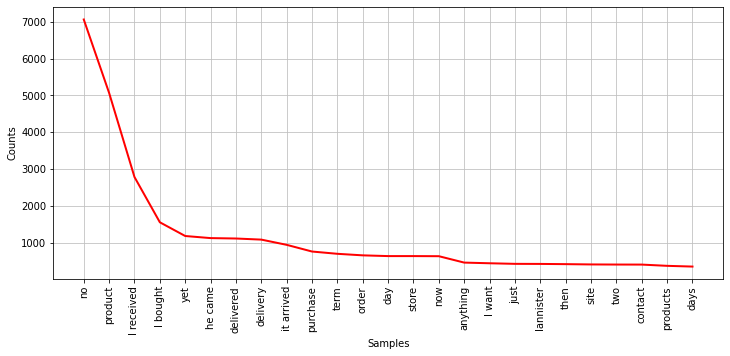

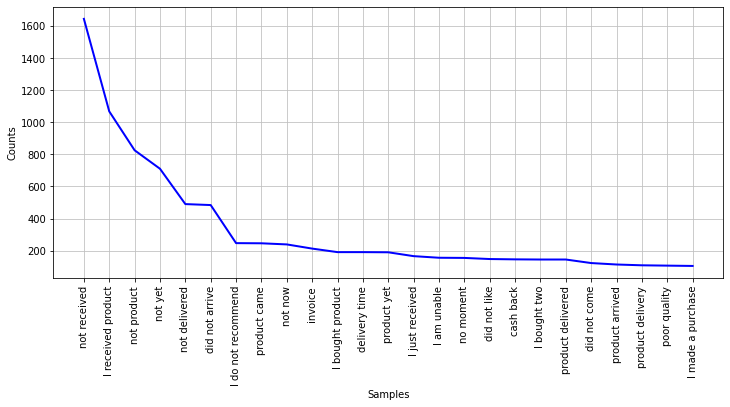

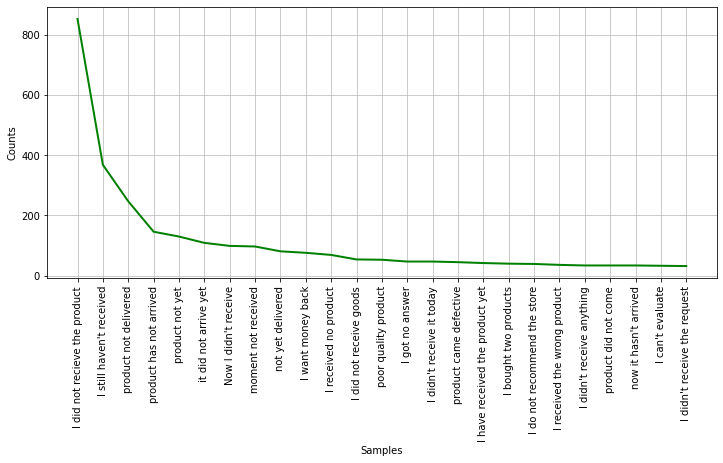

In [ ]:
plot_freq(uni_1s, "red")
plot_freq(bi_1s, "blue")
plot_freq(tri_1s, "green")

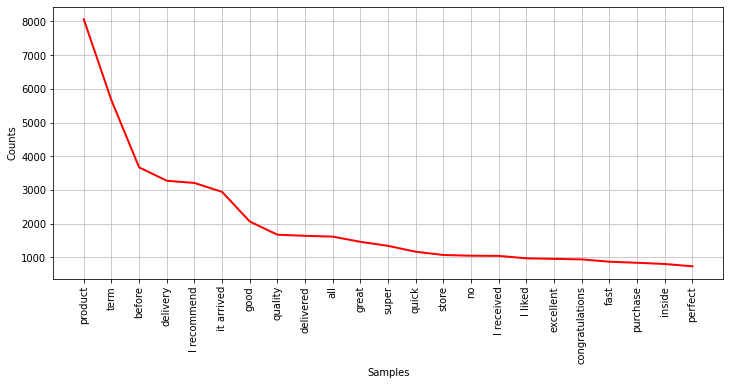

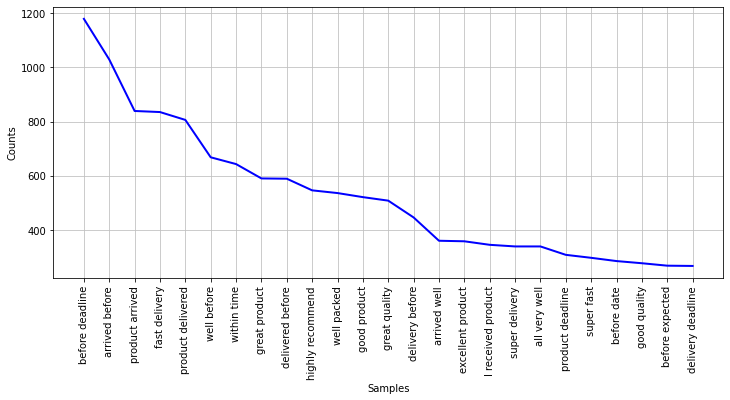

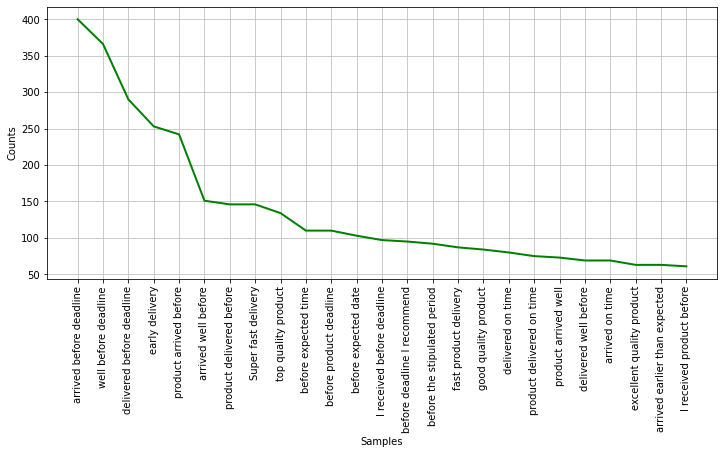

In [ ]:
plot_freq(uni_5s, "red")
plot_freq(bi_5s, "blue")
plot_freq(tri_5s, "green")

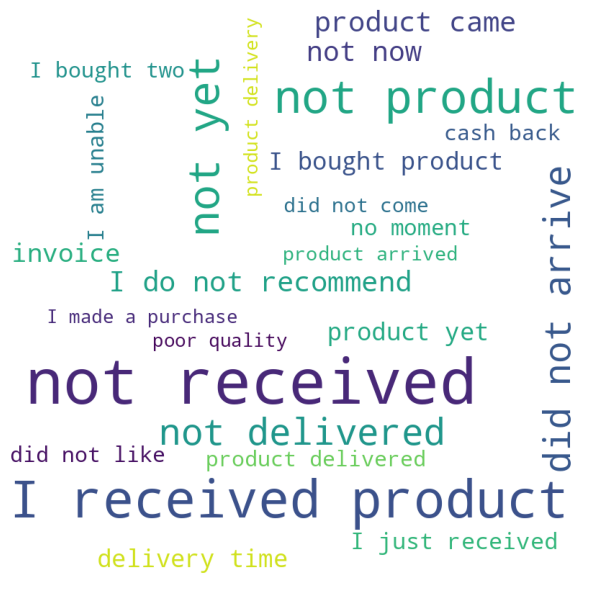

In [ ]:
# Wordcloud visualization of bigrams associated with 1 star reviews
wordcloud_1s = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(bi_1s)

# Plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_1s)
plt.axis("off")
plt.tight_layout(pad=0)
  
# Show the plot
plt.show()

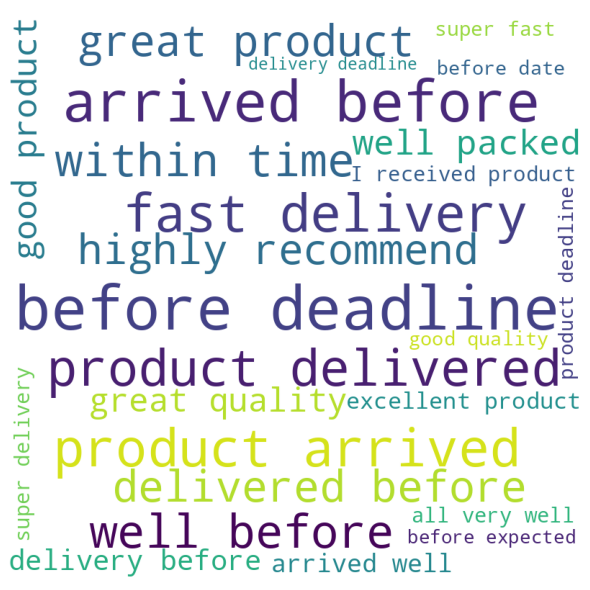

In [ ]:
# Wordcloud visualization of bigrams associated with 5 star reviews
wordcloud_5s = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(bi_5s)

# Plot the wordcloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_5s)
plt.axis("off")
plt.tight_layout(pad=0)
  
# Show the plot
plt.show()

# **Feature Extraction - Using TF-IDF and CountVectorizer**

In [ ]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    corpus: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray() #Extract features from corpus
    features_names = vectorizer.get_feature_names_out()
    
    # Transforming into a dataframe
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

### **CountVectorizer**

In [ ]:
reviews_tokenised = [' '.join(review) for review in df_comments['review_comment_words']]
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_tokenised, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of dataframe of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of dataframe of corpus features:


,acabamento,achei,acho,acordo,adorei,agora,aguardando,aguardo,ainda,alem,...,vcs,veio,vem,vendedor,ver,vez,vezes,vieram,volta,vou
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### **TF-IDF (Term Frequency and Inverse Document Frequency)**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_tokenised, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of dataframe of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of dataframe of corpus features:


,acabamento,achei,acho,acordo,adorei,agora,aguardando,aguardo,ainda,alem,...,vcs,veio,vem,vendedor,ver,vez,vezes,vieram,volta,vou
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.326484,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.306575,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.499563,0.0,0.000000,0.0,0.0,0.0,0.0




*   max_features = 300: indicates that the matrix will be created using the 300 most common words from the corpus
*   max_df = 0.8: indicates that we will use only words with at least 80% frequency in the corpus
*   min_df = 7: indicates that we will use only words that occurs in at least 7 text strings in the corpus



## **Implement Models**

**Logistic Regression**

In [ ]:
x = reviews_tokenised

y = df_comments['sentiment'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=2023)

y_train = y_train.astype(np.float32) 
y_test = y_test.astype(np.float32)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer (CV)
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords)
count_vectorizer.fit(np.concatenate((x_train, x_test), axis=0))

X_train_matrix = count_vectorizer.transform(x_train)
X_test_matrix = count_vectorizer.transform(x_test)
x_full_matrix = count_vectorizer.transform(np.concatenate((x_train, x_test), axis=0))

from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer() #compute word counts, generate idf values and then compute a tfidf score
tfidf_transformer.fit(x_full_matrix)
X_train_dtm_tfidf = tfidf_transformer.transform(X_train_matrix)
X_test_dtm_tfidf  = tfidf_transformer.transform(X_test_matrix)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Negative','Positive']

def class_report(y_test, y_pred, title="", labels=labels):
    if(title != ''):
        print(title,"\n")
    print(confusion_matrix(y_test, y_pred), '\n')
    print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_matrix, y_train)
y_pred = logreg.predict(X_test_matrix)
class_report(y_test, y_pred, "Logistic Regression")
print('Model Accuracy:', accuracy_score(y_test, y_pred))

Logistic Regression 

[[2356  592]
 [ 364 4884]] 

              precision    recall  f1-score   support

    Negative       0.87      0.80      0.83      2948
    Positive       0.89      0.93      0.91      5248

    accuracy                           0.88      8196
   macro avg       0.88      0.86      0.87      8196
weighted avg       0.88      0.88      0.88      8196

Model Accuracy: 0.8833577354807223


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, logreg.predict_proba(X_test_matrix)[:, 1])

0.9362760084865307

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_matrix.toarray(), y_train)
y_pred = gnb.predict(X_test_matrix.toarray())
class_report(y_test, y_pred, "Gaussian Naive Bayes")
print('Model Accuracy:', accuracy_score(y_test, y_pred))

Gaussian Naive Bayes 

[[2080  868]
 [ 529 4719]] 

              precision    recall  f1-score   support

    Negative       0.80      0.71      0.75      2948
    Positive       0.84      0.90      0.87      5248

    accuracy                           0.83      8196
   macro avg       0.82      0.80      0.81      8196
weighted avg       0.83      0.83      0.83      8196

Model Accuracy: 0.829551000488043


In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier() 
forest.fit(X_train_matrix, y_train)
y_pred = forest.predict(X_test_matrix)
class_report(y_test, y_pred, "Random Forest Classifier")
print('Model Accuracy:', accuracy_score(y_test, y_pred))

Random Forest Classifier 

[[2412  536]
 [ 451 4797]] 

              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      2948
    Positive       0.90      0.91      0.91      5248

    accuracy                           0.88      8196
   macro avg       0.87      0.87      0.87      8196
weighted avg       0.88      0.88      0.88      8196

Model Accuracy: 0.8795754026354319


## **LSTM model**

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

In [ ]:
# Tokenizer
maxlen = 130
max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(np.concatenate((x_train, x_test), axis=0))

# Convert x_train
list_tokenized_train = tokenizer.texts_to_sequences(x_train) # convert string to numbers
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) # create a array of 130 spaces and put all words at the end

## Convert x_test to numerical
X_tt = tokenizer.texts_to_sequences(x_test)
X_tt = pad_sequences(X_tt, maxlen=maxlen)

In [ ]:
#Create LSTM model

model = Sequential()
model.add(Embedding(max_features, 128))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 5
history = model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, validation_data=(X_tt, y_test))

Epoch 1/5
328/328 [==============================] - 131s 382ms/step - loss: 0.3516 - accuracy: 0.8543 - val_loss: 0.2766 - val_accuracy: 0.8975
Epoch 2/5
328/328 [==============================] - 125s 383ms/step - loss: 0.2564 - accuracy: 0.9098 - val_loss: 0.2735 - val_accuracy: 0.8969
Epoch 3/5
328/328 [==============================] - 127s 387ms/step - loss: 0.2275 - accuracy: 0.9218 - val_loss: 0.2858 - val_accuracy: 0.8946
Epoch 4/5
251/328 [=====================>........] - ETA: 27s - loss: 0.1992 - accuracy: 0.9346

In [ ]:
y_pred = model.predict_classes(X_tt)

class_report(y_test, y_pred, "LSTM Model", labels)

**References: **

1. https://www.kaggle.com/code/krnilo/customer-reviews-analysis-brazilian-e-commerce
2. https://www.kaggle.com/code/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp
3. https://www.kaggle.com/code/juniorbueno/olist-reviews
4. https://www.kaggle.com/code/yichengs/brazilian-e-commerce-rating-prediction#Section-6:-Models
5. https://www.kaggle.com/code/andresionek/predicting-customer-satisfaction





